## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences with Universal tagset
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Check first few tagged sentences
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

As stated in problem, let's divide the Treebank dataset into train and validation sets in ratio of 95:5

In [4]:
# Splitting into train and test dataset
train_set, test_set = train_test_split(nltk_data, random_state = 1000, test_size=0.05)

In [5]:
#Check length of training and test set
print(len(train_set))
print(len(test_set))

#Check first few tagged sentences of training set 
print(train_set[:10])

3718
196
[[('She', 'PRON'), ('says', 'VERB'), ('0', 'X'), ('she', 'PRON'), ('offered', 'VERB'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('a', 'DET'), ('quiet', 'ADJ'), ('resignation', 'NOUN'), ('and', 'CONJ'), ('thought', 'VERB'), ('0', 'X'), ('she', 'PRON'), ('could', 'VERB'), ('help', 'VERB'), ('*-1', 'X'), ('save', 'VERB'), ('her', 'PRON'), ('teaching', 'NOUN'), ('certificate', 'NOUN'), ('.', '.')], [('Program', 'NOUN'), ('trading', 'NOUN'), ('money', 'NOUN'), ('managers', 'NOUN'), ('have', 'VERB'), ('gained', 'VERB'), ('control', 'NOUN'), ('over', 'ADP'), ('a', 'DET'), ('big', 'ADJ'), ('chunk', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('invested', 'VERB'), ('funds', 'NOUN'), ('in', 'ADP'), ('this', 'DET'), ('country', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('the', 'DET'), ('pressures', 'NOUN'), ('*ICH*-2', 'X'), ('on', 'ADP'), ('such', 'ADJ'), ('money', 'NOUN'), ('managers', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('produce', 'VERB'), ('consistent', 'ADJ'), ('profits', 'NOUN'), ('has', 'V

In [6]:
# Get list of tagged words from training set
train_tagged_words = [tup for sentence in train_set for tup in sentence]
len(train_tagged_words)

95414

In [7]:
#Check first few words along with their tags
train_tagged_words[:10]

[('She', 'PRON'),
 ('says', 'VERB'),
 ('0', 'X'),
 ('she', 'PRON'),
 ('offered', 'VERB'),
 ('Mrs.', 'NOUN'),
 ('Yeargin', 'NOUN'),
 ('a', 'DET'),
 ('quiet', 'ADJ'),
 ('resignation', 'NOUN')]

In [8]:
# Get list of words/tokens from training set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['She',
 'says',
 '0',
 'she',
 'offered',
 'Mrs.',
 'Yeargin',
 'a',
 'quiet',
 'resignation']

In [9]:
# Get vocabulary from training set
vocabulary = set(tokens)
print(len(vocabulary))

12032


In [10]:
# Get list of tags
tags = set([pair[1] for pair in train_tagged_words])
print(tags)

{'.', 'PRON', 'X', 'NOUN', 'ADP', 'VERB', 'ADJ', 'ADV', 'DET', 'CONJ', 'PRT', 'NUM'}


There are total 12 tags in the tagset.

### Build the vanilla Viterbi based POS tagger

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. In other words, to every word w, assign the tag t that maximises the likelihood P(t/w).

Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

Now:

- Emission probability OR P(w/t) is the probability of a given word for a given tag. This can be computed based on the fraction of given word for given tag to the total count of that tag, ie: P(w/t) = count(w, t) / count(t).

- Transition probability OR P(t) is the probability of tag, and in a tagging task, we assume that a tag will depend only on the previous tag (Markov order 1 assumption). In other words, the probability of say a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun.

#### Calculate Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(tags)
v = len(vocabulary)
w_given_t = np.zeros((t, v))

In [12]:
# compute Emission probability i.e. word given tag
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

Let's run this function for few words and tags and check the emission probability of these pairs.

In [13]:
# bright
print("\n", "bright")
print(word_given_tag('language', 'PRON'))
print(word_given_tag('language', 'NOUN'))

# is
print("\n", "is")
print(word_given_tag('is', 'DET'))
print(word_given_tag('is', 'VERB'))

# growing
print("\n", "growing")
print(word_given_tag('growing', 'VERB'))
print(word_given_tag('growing', 'ADP'))


 bright
(0, 2592)
(6, 27347)

 is
(0, 8257)
(630, 12848)

 growing
(22, 12848)
(0, 9365)


#### Compute Transition Probabilities

In [14]:
# compute transition probability i.e. probability of a tag occuring after another tag: tag2(t2) given tag1 (t1)

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

Let's run this function on few tags and check the transition probabilities for few tags pairs.

In [15]:
# examples
print(t2_given_t1('PRON', 'ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('PRON', 'VERB'))
print(t2_given_t1('VERB', 'PRON'))

(4, 6080)
(4252, 6080)
(5264, 8257)
(450, 12848)
(1262, 2592)


Let's store these emission probabilities in a matrix.

In [16]:
# creating t x t transition matrix of tags where each column is t2, each row is t1
# M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
tags_matrix

array([[9.18597281e-02, 6.58974126e-02, 2.66834944e-02, 2.22212210e-01,
        9.11385566e-02, 8.96060616e-02, 4.42621484e-02, 5.30965477e-02,
        1.74073741e-01, 5.79644814e-02, 2.34382041e-03, 8.07716548e-02],
       [3.93518507e-02, 8.10185168e-03, 9.06635821e-02, 2.12191358e-01,
        2.27623452e-02, 4.86882716e-01, 7.33024701e-02, 3.47222239e-02,
        8.87345709e-03, 4.62962966e-03, 1.11882715e-02, 7.33024674e-03],
       [1.64033830e-01, 5.56885265e-02, 7.48364478e-02, 6.23902977e-02,
        1.44566774e-01, 2.04882726e-01, 1.64352953e-02, 2.45731603e-02,
        5.45715652e-02, 1.03717884e-02, 1.84936970e-01, 2.71262159e-03],
       [2.40209162e-01, 4.38804971e-03, 2.92170979e-02, 2.63648659e-01,
        1.77350342e-01, 1.46341458e-01, 1.23962406e-02, 1.72962304e-02,
        1.29081802e-02, 4.24909480e-02, 4.42461707e-02, 9.50744096e-03],
       [3.96155901e-02, 6.94073662e-02, 3.55579294e-02, 3.20128143e-01,
        1.67645495e-02, 8.32888391e-03, 1.07848369e-01, 1.31

In [18]:
# convert the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,.,PRON,X,NOUN,ADP,VERB,ADJ,ADV,DET,CONJ,PRT,NUM
.,0.091860,0.065897,0.026683,0.222212,0.091139,0.089606,0.044262,0.053097,0.174074,0.057964,0.002344,0.080772
PRON,0.039352,0.008102,0.090664,0.212191,0.022762,0.486883,0.073302,0.034722,0.008873,0.004630,0.011188,0.007330
X,0.164034,0.055689,0.074836,0.062390,0.144567,0.204883,0.016435,0.024573,0.054572,0.010372,0.184937,0.002713
NOUN,0.240209,0.004388,0.029217,0.263649,0.177350,0.146341,0.012396,0.017296,0.012908,0.042491,0.044246,0.009507
ADP,0.039616,0.069407,0.035558,0.320128,0.016765,0.008329,0.107848,0.013134,0.324399,0.000961,0.001388,0.062467
VERB,0.034714,0.035025,0.217388,0.111146,0.092310,0.168742,0.064679,0.081102,0.134729,0.005526,0.031367,0.023272
ADJ,0.065461,0.000658,0.020888,0.699342,0.077303,0.011513,0.067105,0.004605,0.004605,0.017105,0.010691,0.020724
ADV,0.136016,0.015298,0.022281,0.032923,0.118390,0.346192,0.129365,0.081809,0.066511,0.006984,0.013967,0.030263
DET,0.017924,0.003754,0.045658,0.637520,0.009325,0.039966,0.205038,0.012716,0.005329,0.000484,0.000242,0.022042
CONJ,0.037279,0.059180,0.008388,0.346692,0.053122,0.159366,0.117428,0.054986,0.116962,0.000466,0.005126,0.041007


In [19]:
#See the probability of sentence starting with a particular tag
tags_df.loc['.', :]

.       0.091860
PRON    0.065897
X       0.026683
NOUN    0.222212
ADP     0.091139
VERB    0.089606
ADJ     0.044262
ADV     0.053097
DET     0.174074
CONJ    0.057964
PRT     0.002344
NUM     0.080772
Name: ., dtype: float32

We can observe from above result that probability of a sentenc starting with Noun is highest (22%) followed by Determiner (17.4%).

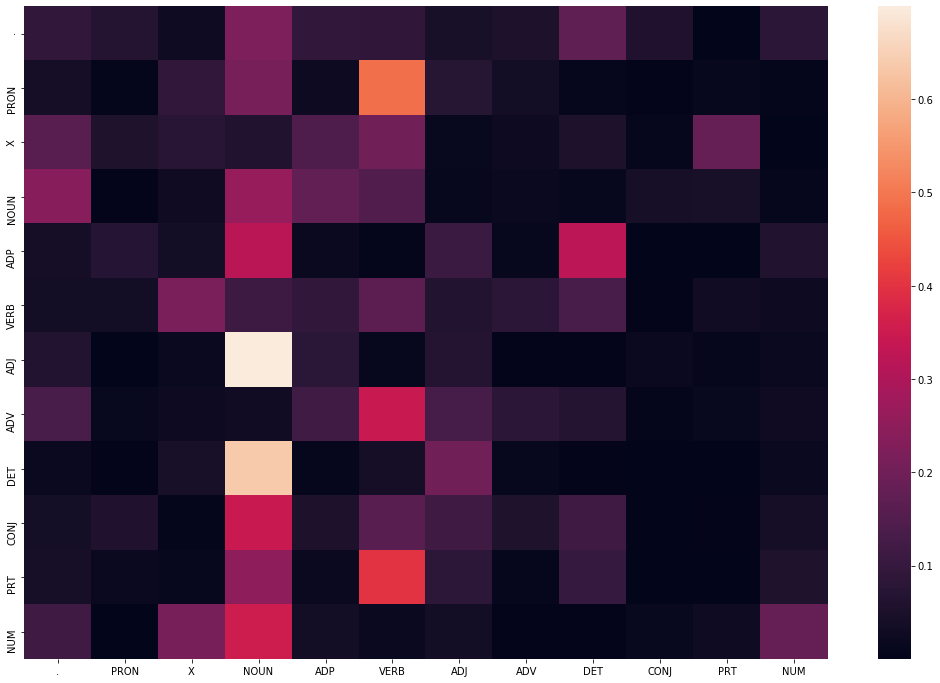

In [20]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

Let's filter out the pair of tags with high probabilities of occuring in conjuction.

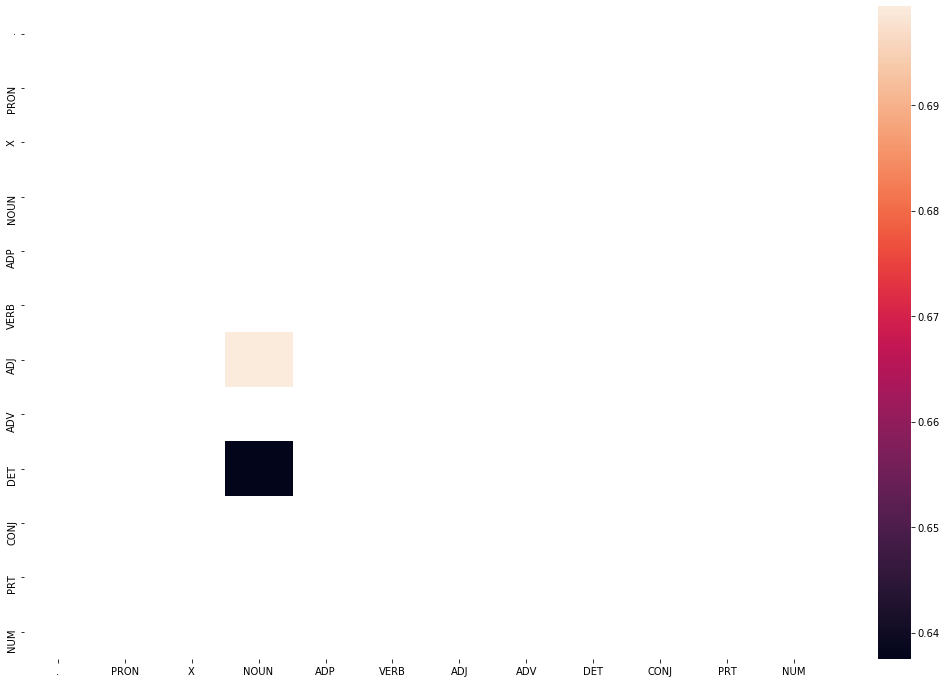

In [21]:
# frequent tags
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

It can be observed from above heatmap that probability of noun being followed by Adjective and Determiner are highest.

### Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [22]:
len(train_tagged_words)

95414

In [23]:
# Viterbi Heuristic
def Viterbi_Vanilla(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [24]:
# list of tagged words
test_run_base = [tup for sentence in test_set for tup in sentence]
test_run_base

# list of words
test_tagged_words = [tup[0] for sentence in test_set for tup in sentence]
len(test_tagged_words)

5262

In [25]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(100)

# choose random 5 sentences
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sentences
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [26]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Vanilla(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  37.65242886543274


In [27]:
# get accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

vanilla_viterbi_accuracy = len(check)*100/len(tagged_seq)
print('Vanilla Viterbi Algorithm Accuracy: ', vanilla_viterbi_accuracy)

Vanilla Viterbi Algorithm Accuracy:  90.06211180124224


### Solve the problem of unknown words

In order to increase the accuracy of out algorithm, we need to find out the words which were tagged incorrectly by vanila viterbi algorithm and then analyze this data to check what all improvements can be made.

In [28]:
#Get list of words which were tagged incorrectly by vanila viterbi
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[(('continuingly', '.'), ('continuingly', 'ADV')),
 (('directed', '.'), ('directed', 'VERB')),
 (('mining', '.'), ('mining', 'NOUN')),
 (('hugging', '.'), ('hugging', 'VERB')),
 (('matters', 'NOUN'), ('matters', 'VERB')),
 (('*T*-15', '.'), ('*T*-15', 'X')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('plaintive', '.'), ('plaintive', 'ADJ')),
 (('high-minded', '.'), ('high-minded', 'ADJ')),
 (('assurance', '.'), ('assurance', 'NOUN')),
 (('reading', 'NOUN'), ('reading', 'VERB')),
 (('sticky', '.'), ('sticky', 'ADJ')),
 (('fingers', '.'), ('fingers', 'NOUN')),
 (('sweaty', '.'), ('sweaty', 'ADJ')),
 (('Eliminate', '.'), ('Eliminate', 'VERB')),
 (('more', 'ADV'), ('more', 'ADJ'))]

In [29]:
len(incorrect_tagged_cases)

16

From above set it is clear that all unknown words are tagged with Tag ADJ as this is the first tag in tags list. If an unknown word is countered then this tag is assigned as the emission probability for an unknown word is 0.

Let's modify the vanila Viterbi algorithm to tackle this problem.


### Viterbi Modification-Technique I


First solution for unknown words: 
We can do the assignment based on transition probabilities in case of of unknown words since emission probability for unknown word is zero and vanilla viterbi algorithm is assigning ADJ tag to all unknown words which is resulting in tagging errors.


In [30]:
# Viterbi Heuristic
def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            
            # getting state for which transition probability is maximum
            state_max = T[p_transition.index(pmax)]
                           
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
        
    return list(zip(words, state))

In [31]:
# tagging the test sentences
tagged_seq_modified = Viterbi_modified(test_tagged_words)

In [32]:
# accuracy
check = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j] 
modified_viterbi_accuracy = len(check)/len(tagged_seq)
modified_viterbi_accuracy

0.9316770186335404

#### Adding Tag occurance probability weights

we will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

This scheme will also take into account that some POS tags are more likely to occur as compared to others.

In [33]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('.', 0.11626176452092984),
 ('PRON', 0.027165824721738948),
 ('X', 0.06568218500429707),
 ('NOUN', 0.28661412371350115),
 ('ADP', 0.09815121470643721),
 ('VERB', 0.1346552916762739),
 ('ADJ', 0.06372230490284445),
 ('ADV', 0.03151529125704823),
 ('DET', 0.0865386630892741),
 ('CONJ', 0.022491458276563188),
 ('PRT', 0.032007881442974825),
 ('NUM', 0.03519399668811705)]

In [34]:
def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [35]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modified(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  36.441455125808716


In [36]:
modified_viterbi_accuracy = len(check)*100/len(tagged_seq)
print('Modified Accuracy using weighted probability is: ',modified_viterbi_accuracy)

Modified Accuracy using weighted probability is:  93.16770186335404


In [37]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('continuingly', 'NOUN'), ('continuingly', 'ADV')),
 (('directed', 'NOUN'), ('directed', 'VERB')),
 (('matters', 'NOUN'), ('matters', 'VERB')),
 (('*T*-15', 'NOUN'), ('*T*-15', 'X')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('plaintive', 'NOUN'), ('plaintive', 'ADJ')),
 (('high-minded', 'NOUN'), ('high-minded', 'ADJ')),
 (('reading', 'NOUN'), ('reading', 'VERB')),
 (('sticky', 'NOUN'), ('sticky', 'ADJ')),
 (('sweaty', 'NOUN'), ('sweaty', 'ADJ')),
 (('more', 'ADV'), ('more', 'ADJ'))]

The following list of words have been correctly POS tagged by modified Viterbi as compared to vanilla Viterbi Algorithm:

- mining: correctly tagged as NOUN
- hugging: correctly tagged as VERB
- assurance: correctly tagged as NOUN
- fingers: correctly tagged as NOUN
- Eliminate: correctly tagged as VERB 

### Viterbi Modification-Technique II
second solution for unknown words:

backoff to rule based tagger in case of unknown words.
Let's define a rule based tagger as below:

In [38]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [39]:
# Modification in Viterbi Algorithm : Backoff to rule based tagger in case unknown word is encountered.
def Viterbi_rulebased(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))

In [40]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_rulebased(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  37.53449773788452


In [41]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_viterbi_accuracy = len(check)*100/len(tagged_seq)
print('Modified rulebased Viterbi Accuracy: ', rulebased_viterbi_accuracy)

Modified rulebased Viterbi Accuracy:  92.54658385093168


In [42]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('continuingly', 'NOUN'), ('continuingly', 'ADV')),
 (('mining', 'VERB'), ('mining', 'NOUN')),
 (('matters', 'NOUN'), ('matters', 'VERB')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('plaintive', 'NOUN'), ('plaintive', 'ADJ')),
 (('high-minded', 'VERB'), ('high-minded', 'ADJ')),
 (('note', 'VERB'), ('note', 'NOUN')),
 (('reading', 'NOUN'), ('reading', 'VERB')),
 (('sticky', 'NOUN'), ('sticky', 'ADJ')),
 (('sweaty', 'NOUN'), ('sweaty', 'ADJ')),
 (('Eliminate', 'NOUN'), ('Eliminate', 'VERB')),
 (('more', 'ADV'), ('more', 'ADJ'))]

Further modification in rule based Viterb: We know that the rule based tagger assigns 'NOUN' by default if word does not fall in any rule, to correct this let's assign the tags for any such word based purely on transition probability of tags.

So, first we will modify the rule based tagger to output 'NN' instead of 'NOUN' in case word does not satisfy any rules. We also observe that any capitalized word can still be defaulted as 'NOUN' so will add one more rule for that case.

In [43]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [44]:
# modified Viterbi
def Viterbi_rulebased(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [45]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_rulebased(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  37.37566018104553


In [46]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_viterbi_accuracy = len(check)*100/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy: ',rulebased_viterbi_accuracy)

Modified Viterbi Algorithm Accuracy:  92.54658385093168


In [47]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('continuingly', 'NOUN'), ('continuingly', 'ADV')),
 (('mining', 'VERB'), ('mining', 'NOUN')),
 (('matters', 'NOUN'), ('matters', 'VERB')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('plaintive', 'NOUN'), ('plaintive', 'ADJ')),
 (('high-minded', 'VERB'), ('high-minded', 'ADJ')),
 (('note', 'VERB'), ('note', 'NOUN')),
 (('reading', 'NOUN'), ('reading', 'VERB')),
 (('sticky', 'NOUN'), ('sticky', 'ADJ')),
 (('sweaty', 'NOUN'), ('sweaty', 'ADJ')),
 (('Eliminate', 'NOUN'), ('Eliminate', 'VERB')),
 (('more', 'ADV'), ('more', 'ADJ'))]

The following list of words have been correctly POS tagged by rule based Viterbi as compared to vanilla Viterbi Algorithm:

- *T*-15: correctly tagged as X
- directed: correctly tagged as VERB
- hugging: correctly tagged as VERB
- assurance: correctly tagged as NOUN
- fingers: correctly tagged as NOUN

#### Evaluating tagging accuracy

In [48]:
f = open('Sample test sentences.txt')

In [49]:
text = f.read()

In [50]:
sample_test_sent = text.splitlines()

In [51]:
f.close()

In [52]:
sample_test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [53]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]

In [54]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi_Vanilla(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  38.650694847106934


In [55]:
sample_tagged_seq

[('Android', '.'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', '.'),
 ('Android', '.'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', '.'),
 ('worldwide', '.'),
 ('on', 'ADP'),
 ('smartphones', '.'),
 ('since', 'ADP'),
 ('2011', '.'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', '.'),
 ('Google', '.'),
 ('and', 'CONJ'),
 ('Twitter', '.'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', '.'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', '.'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", '.'),
 ('firehose.', '.'),
 ('Twitter', '.'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', '.'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET'),
 ('users', 'NOUN'),
 ('post', 'NOUN'),
 ('

We can see that several words have been misclassified by vanilla Viterbi POS tagger, for example:

Android as ADJ, 
Google as ADJ, 
OS as ADJ

In [56]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi_rulebased(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  39.90813326835632


In [57]:
sample_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

All these cases were correctly POS tagged by Viterbi_2:

- Android as NOUN
- Google as NOUN
- OS as NOUN

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [58]:
print("Vannila Viterbi Accuracy: "+ str(vanilla_viterbi_accuracy))
print("Modified Viterbi Accuracy: "+ str(modified_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_viterbi_accuracy))

Vannila Viterbi Accuracy: 90.06211180124224
Modified Viterbi Accuracy: 93.16770186335404
Rule Based Viterbi Accuracy: 92.54658385093168


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

The following list of words have been correctly POS tagged by modified Viterbi as compared to vanilla Viterbi Algorithm:

- directed: correctly tagged as VERB
- hugging: correctly tagged as VERB
- *T*-15: correctly tagged as X
- fingers: correctly tagged as NOUN
- assurance: correctly tagged as NOUN
- mining: correctly tagged as NOUN
- Eliminate: correctly tagged as VERB

Other than above list following tags got corrected on sample data:
- Words like 'Twitter', 'Android', 'Google' are properly tagged with 'NOUN' in modified Viterbi Algorithm
- Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (All Caps of a word generally will be an abbrevation and it is a noun)